In [2]:
cd ../..

/Users/joeranbosma/stack/Projects/M5Forecast


In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import (BatchCreator, Logger, plot_confidence_series, plot_some_confidence_intervals, 
                   prepare_training, perform_training_scheme)
from model_builder import (get_pinball_losses, get_simple_dense_model, get_simple_dist_model,
                           get_variable_dist_model, get_direct_dist_model)
from flow import (model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model, 
                  save_object, load_object)
from preprocess import (preprocess, get_features, pandas_cat_data, reset_categorical_features, 
                        read_and_preprocess_data)


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
model_dir = 'models/uncertainty/experiment/'
plt.rcParams['font.size'] = 14

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Distribution layer performance

In [4]:
def get_nodes_L10_12(mode):
    nodes_dense_small = [256, 512, 1024]#2, 4, 8, 16, 32, 64, 128]
    nodes_dist2_small = [64, 128, 256]#1, 2, 4, 6, 8, 16, 32]
    nodes_dist4_small = [64, 128, 256]#1, 2, 4, 6, 8, 16, 32]
    nodes_direct_small = [64, 128, 256]#1, 2, 4, 6, 8, 16, 32]
    
    # setup node settings
    if mode == "dense":
        return nodes_dense_small
    elif mode == "dist2":
        return nodes_dist2_small
    elif mode == "dist4":
        return nodes_dist4_small
    elif mode == "direct":
        return nodes_direct_small

def get_nodes_list(mode, size):
    if size == "large":
        return get_nodes_L10_12(mode)
    
    if mode == "dense":
        if size == "all":
            return [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
        elif size == "small":
            return [2, 4, 8, 16, 32, 64, 128]
        else:
            return [256, 512, 1024]
    if mode in ["dist2", "dist4", "direct"]:
        if size == "all":
            return [1, 2, 4, 6, 8, 16, 32, 64, 128, 256]
        elif size == "small":
            return [1, 2, 4, 6, 8, 16, 32]
        else:
            return [64, 128, 256]

**Exp. 1, run 1: small nodes of layers 'direct' and 'dist2'**  
etc..

**Exp. 2, run 1: dense/not dense nodes of layers 'dense', 'dist2', dist'4' and 'direct'**

In [6]:
def transform_experiment_results(run_dir, layer_labels, size):
    ls = []

    for mode in layer_labels:
        m1, m2, m3 = [load_object(run_dir + mode + "_part{}_metrics.pickle".format(i))
                              for i in range(1, 1+3)]

        labels = ['part1', 'part2', 'part3']
        nodes_list = get_nodes_list(mode, size)

        for metrics, label in zip([m1, m2, m3], labels):
            for m, num_nodes in zip(metrics, np.tile(nodes_list, 9)):
                level = list(m.keys())[0]
                score = m['WSPL']
                ls += [[mode, level, num_nodes, label, score]]
    
    df = pd.DataFrame(ls, columns=['layer', 'level', 'nodes', 'part', 'WSPL'])
    return df

df1 = transform_experiment_results(model_dir + "run1_a/", ['direct', 'dist2'], "small")
df2 = transform_experiment_results(model_dir + "run2_a/", ['dist4', 'dense'], "small")
df3 = transform_experiment_results(model_dir + "run3_a/", ['direct', 'dist2', 'dist4', 'dense'], "medium")
# df4 = transform_experiment_results(model_dir + "run5/", ['direct', 'dist2', 'dist4', 'dense'], "large")
df5 = transform_experiment_results(model_dir + "run6/", ['direct', 'dist2'], "large")
df6 = transform_experiment_results(model_dir + "run7/", ['dist4', 'dense'], "large")

df_lgb = transform_experiment_results(model_dir + "lgb-run1/", ['dense', 'dist2', 'dist4', 'direct'], "all")

In [7]:
results_prev = pd.concat((df1, df2, df3, df4, df5, df6))
results = df_lgb
results

,layer,level,nodes,part,WSPL
0,dense,1,2,part1,0.423279
1,dense,1,4,part1,0.074672
2,dense,1,8,part1,0.085376
3,dense,1,16,part1,0.082696
4,dense,1,32,part1,0.082481
...,...,...,...,...,...
1075,direct,9,16,part3,0.145731
1076,direct,9,32,part3,0.155191
1077,direct,9,64,part3,0.136782
1078,direct,9,128,part3,0.139725


In [12]:
results_prev[(results_prev.level >= 10)].groupby(['layer', 'nodes']).min()

level   part      WSPL
layer  nodes                        
dense  256       12  part1  0.266642
       512       12  part1  0.594725
       1024      12  part1  0.594725
direct 64        12  part1  0.266018
       128       12  part1  0.277939
       256       12  part1  0.594725
dist2  64        12  part1  0.296493
       128       12  part1  0.295591
       256       12  part1  0.594600
dist4  64        12  part1  0.282948
       128       12  part1  0.279758
       256       12  part1  0.287956

## Plot per level, per layer

dense


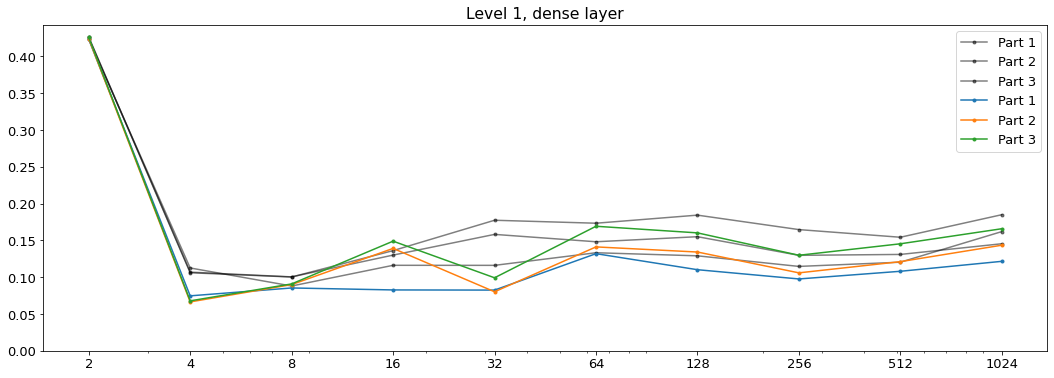

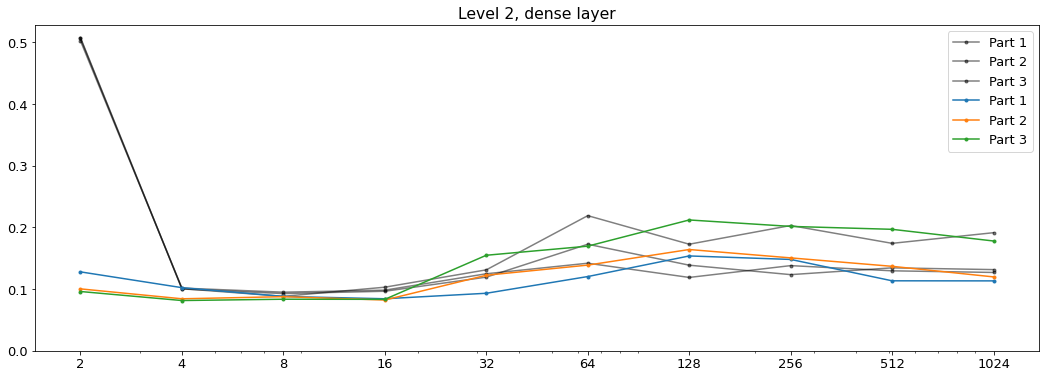

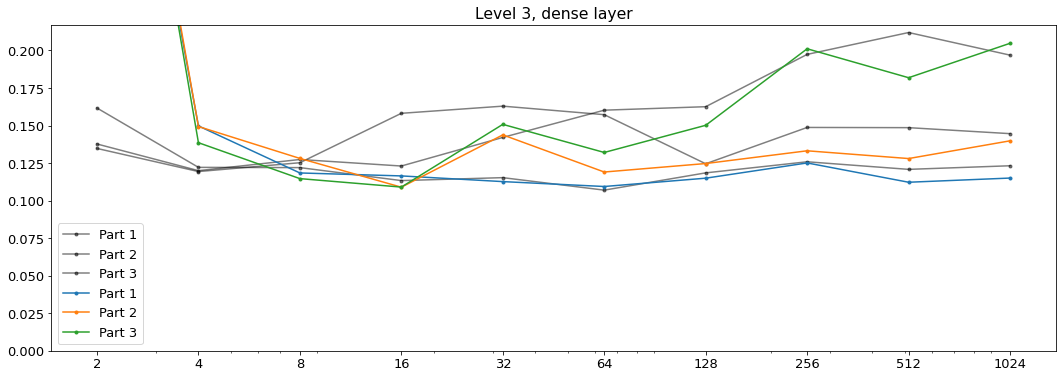

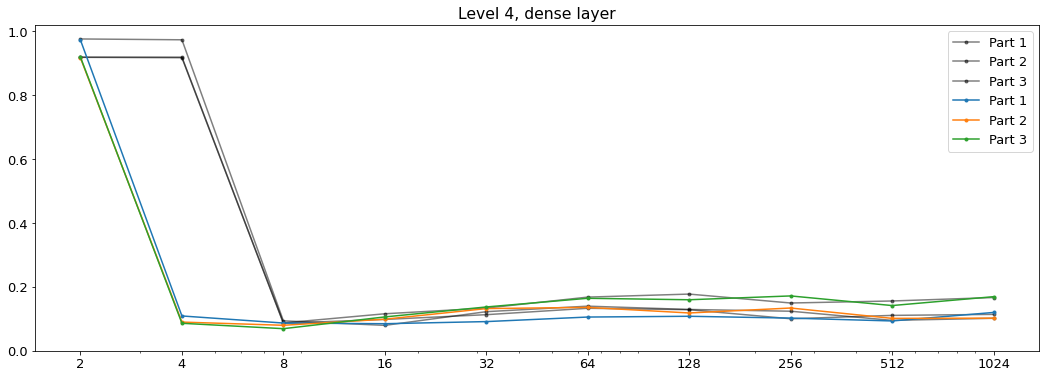

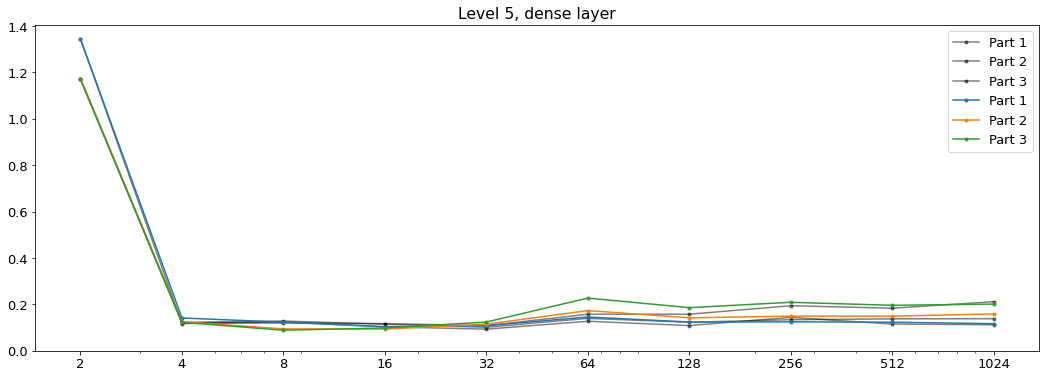

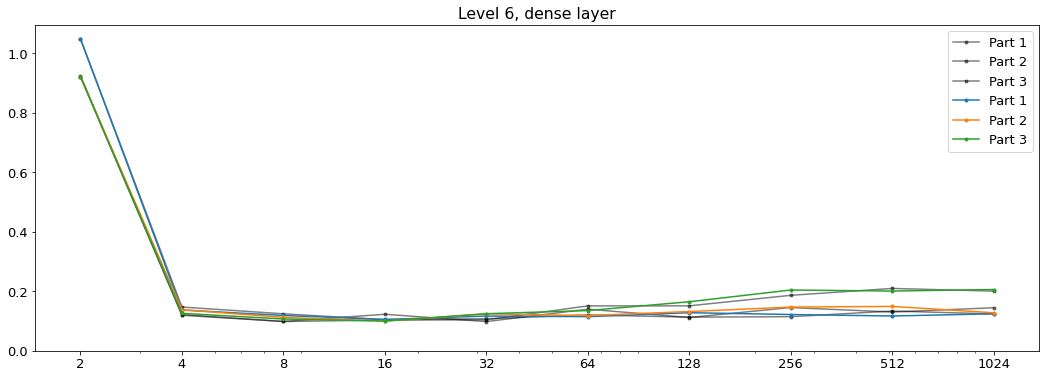

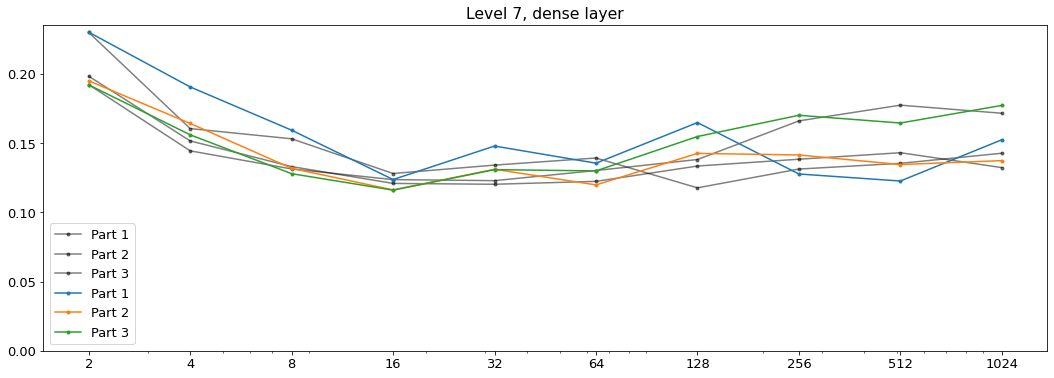

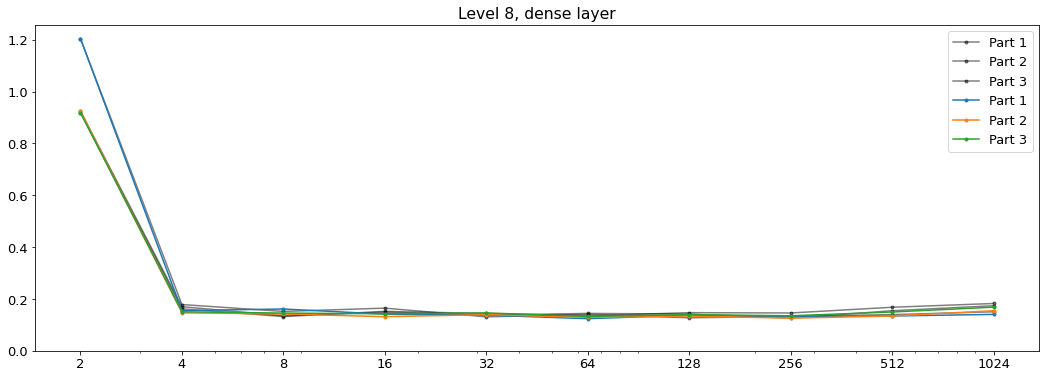

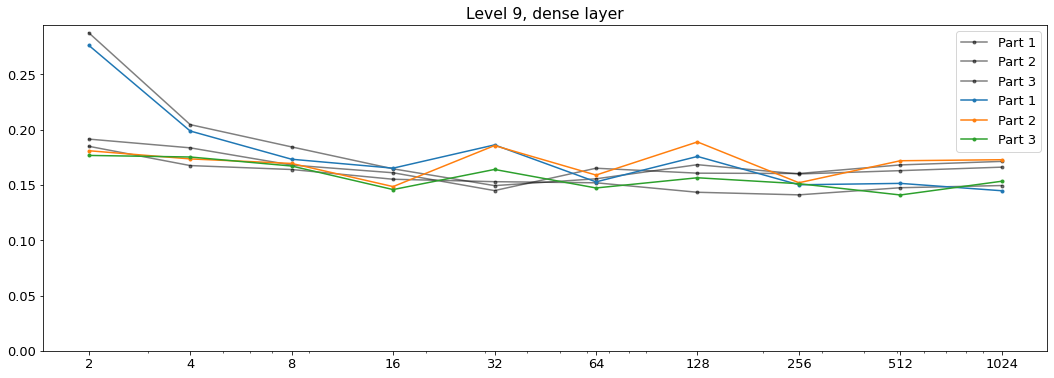

dist2


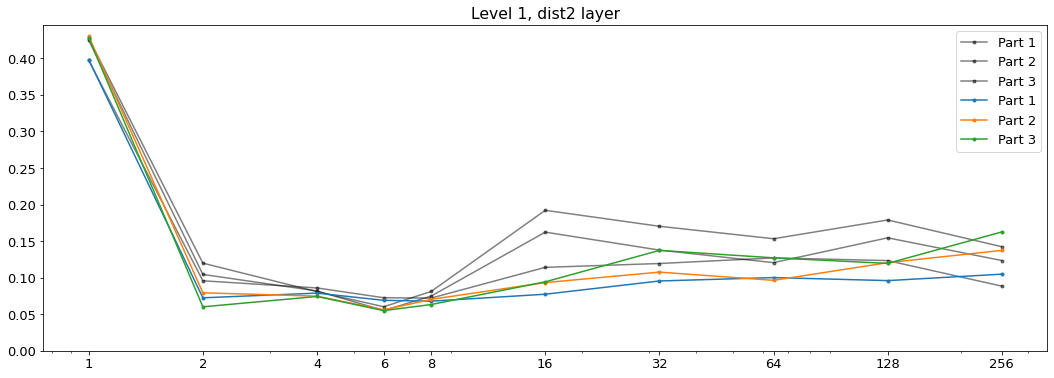

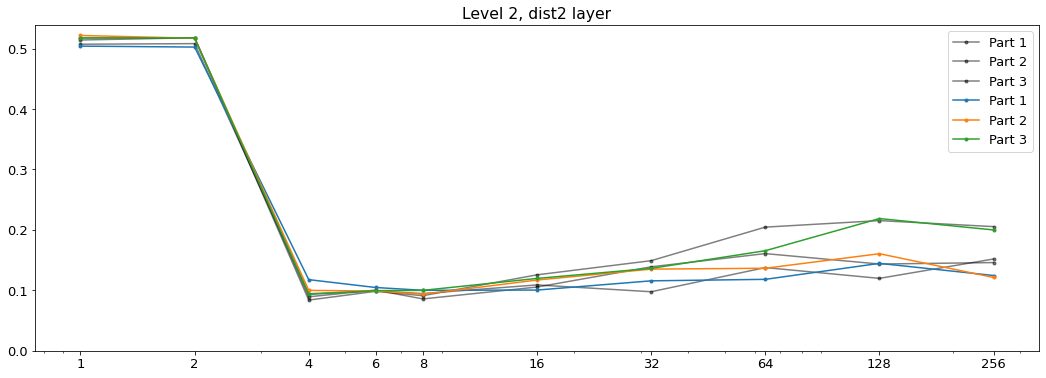

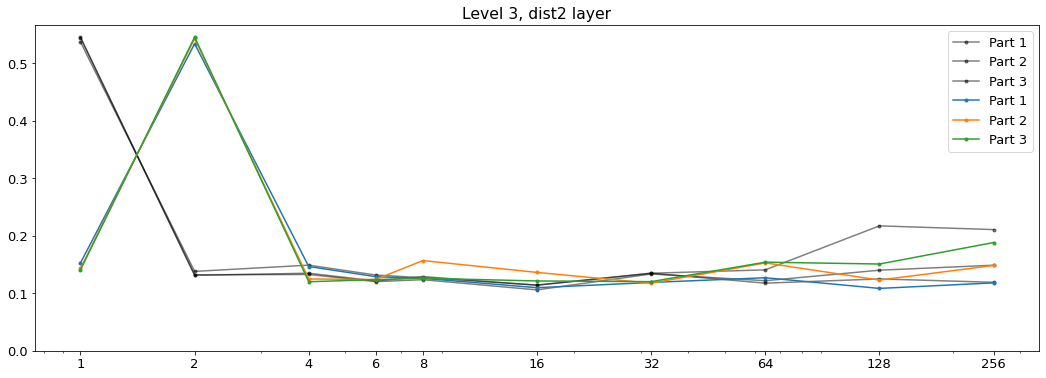

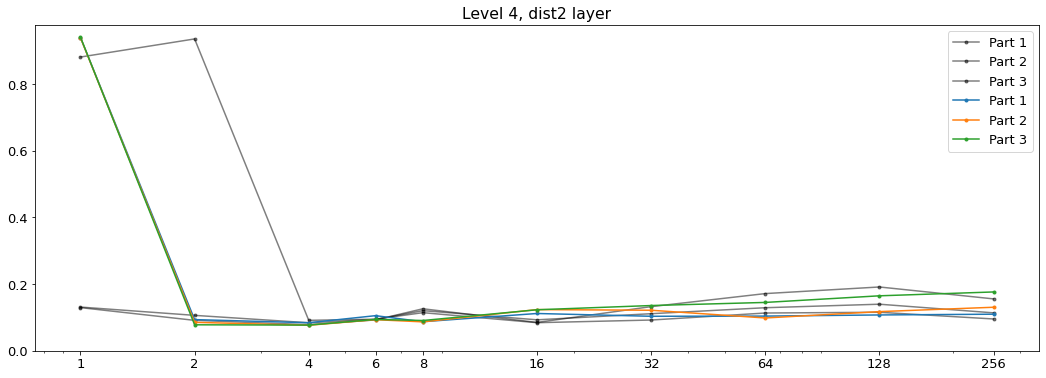

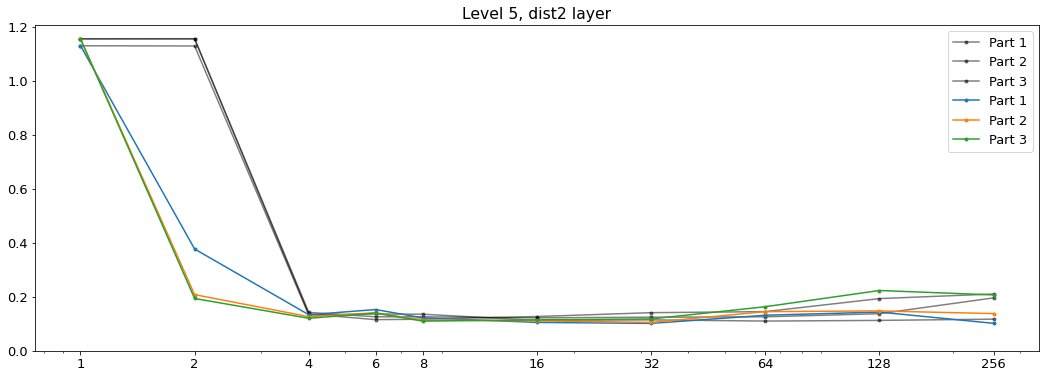

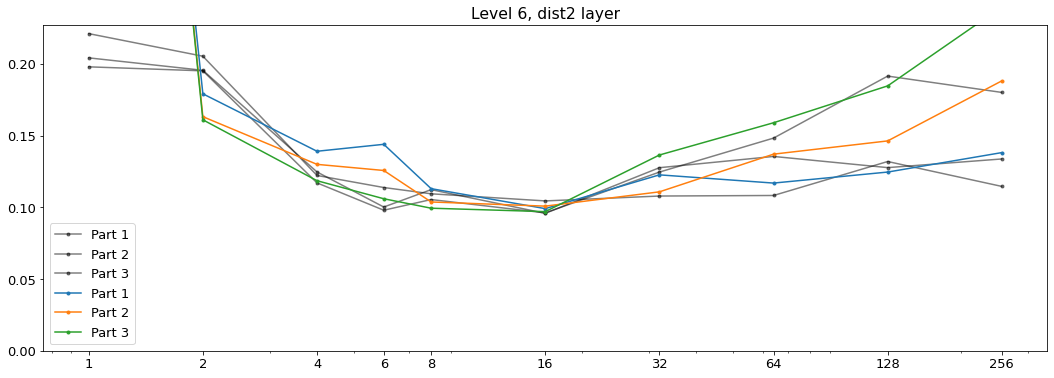

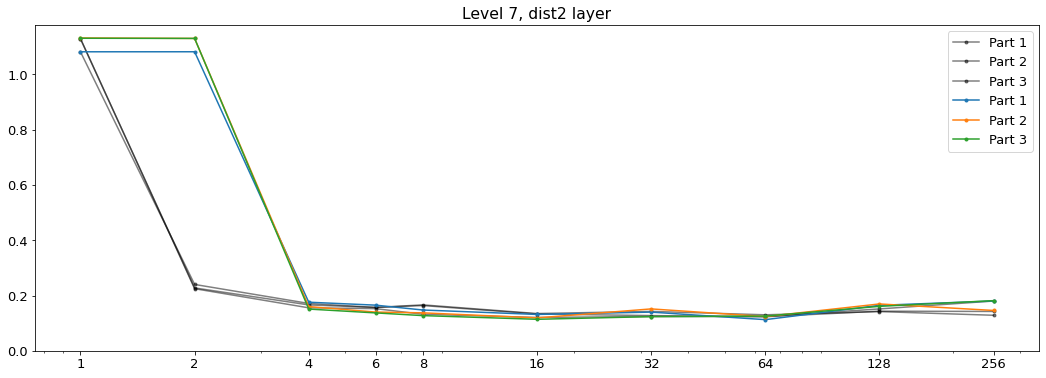

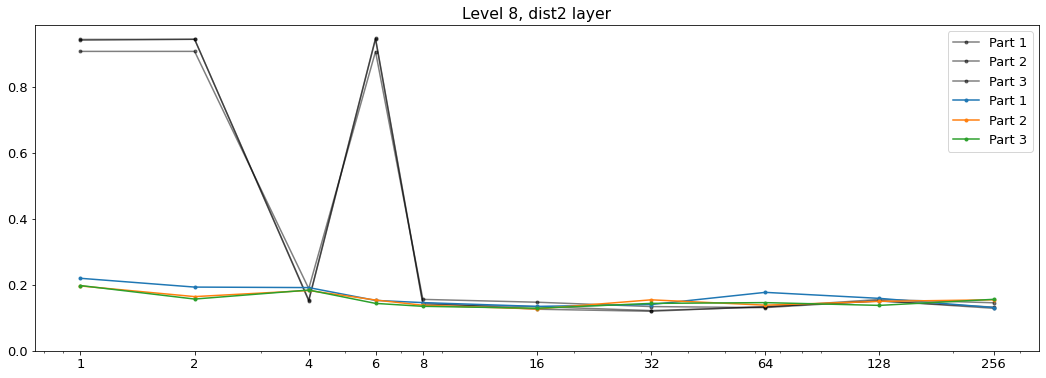

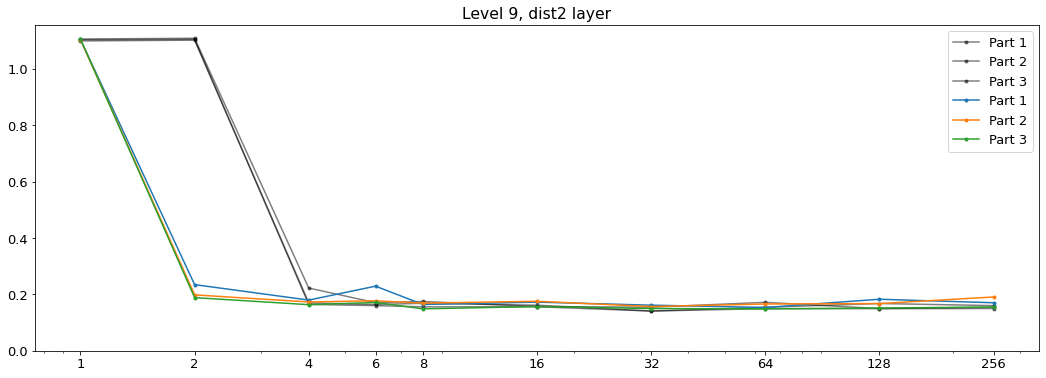

dist4


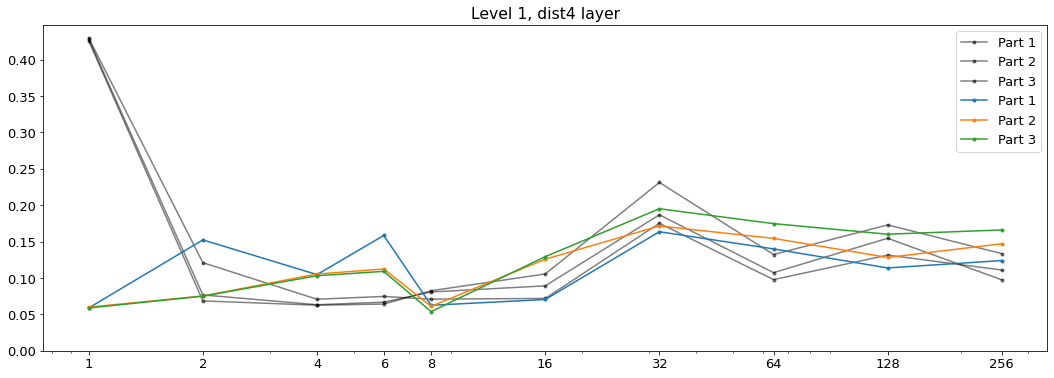

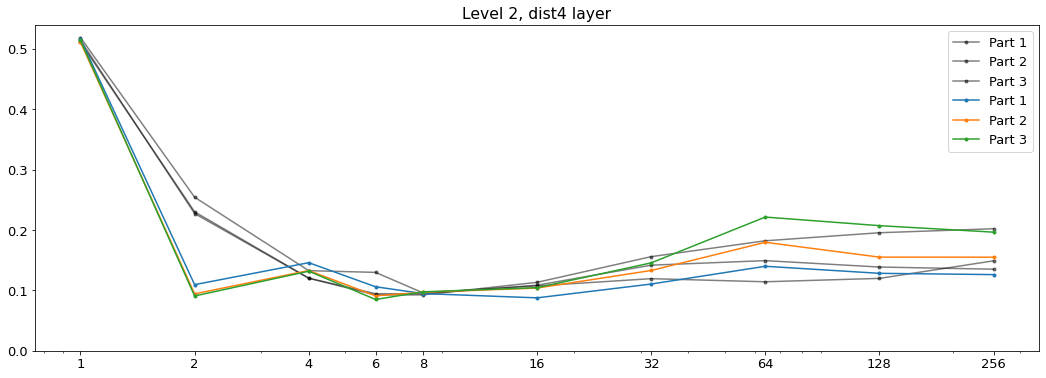

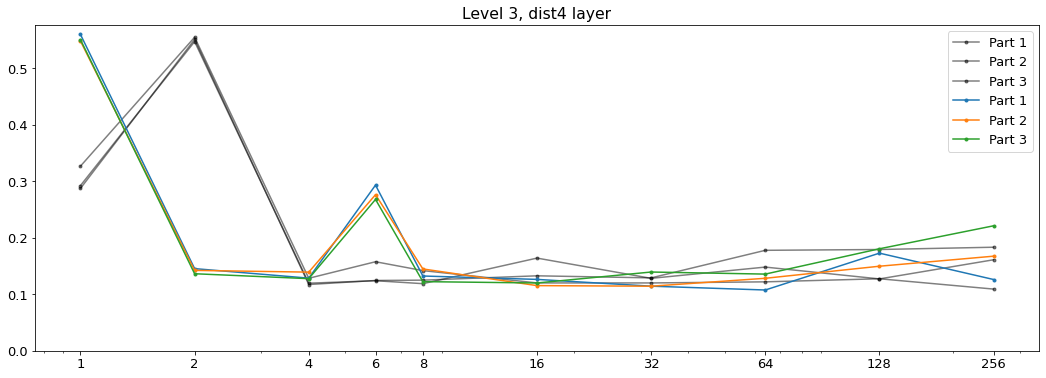

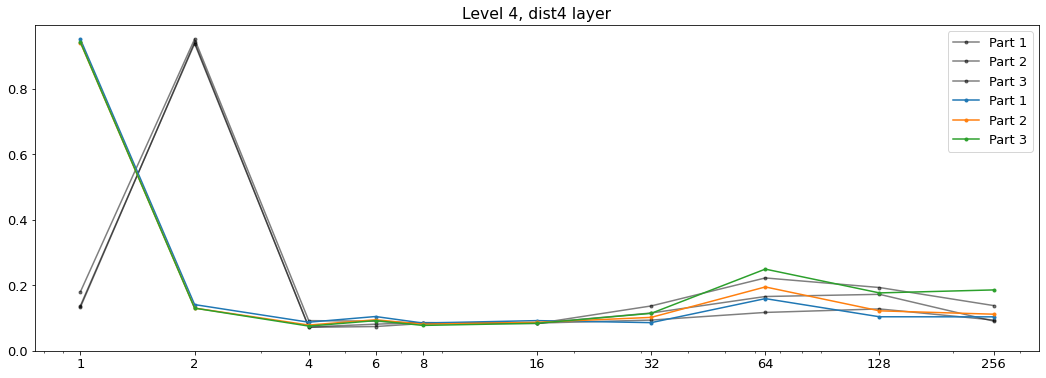

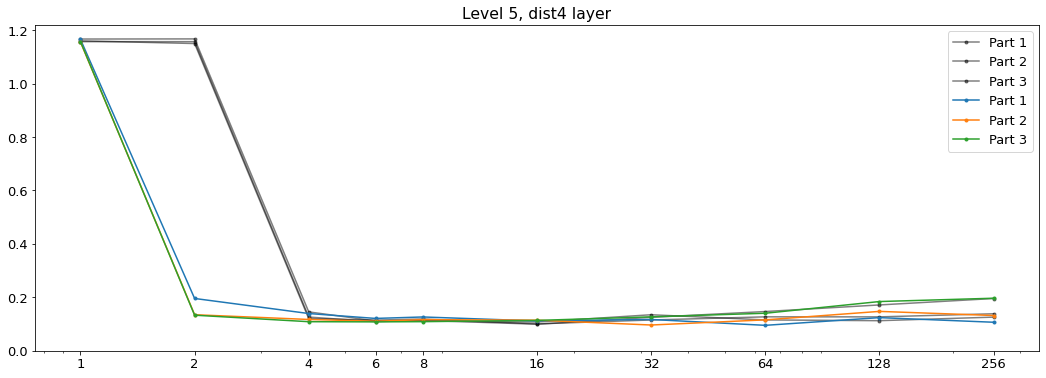

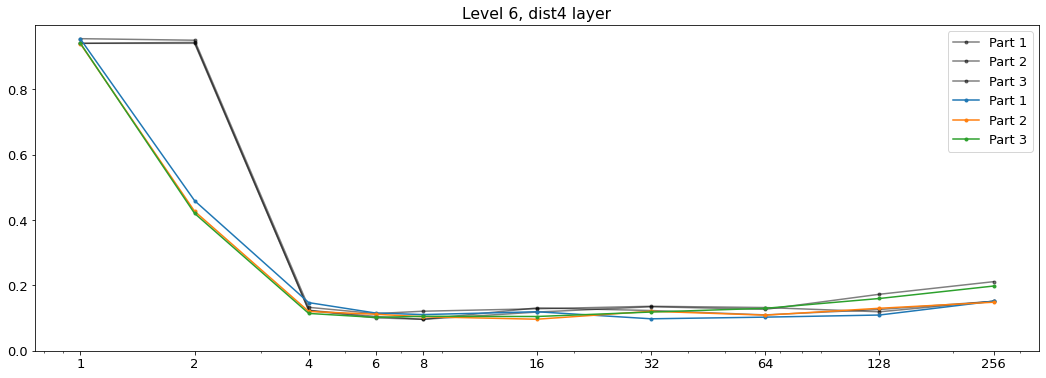

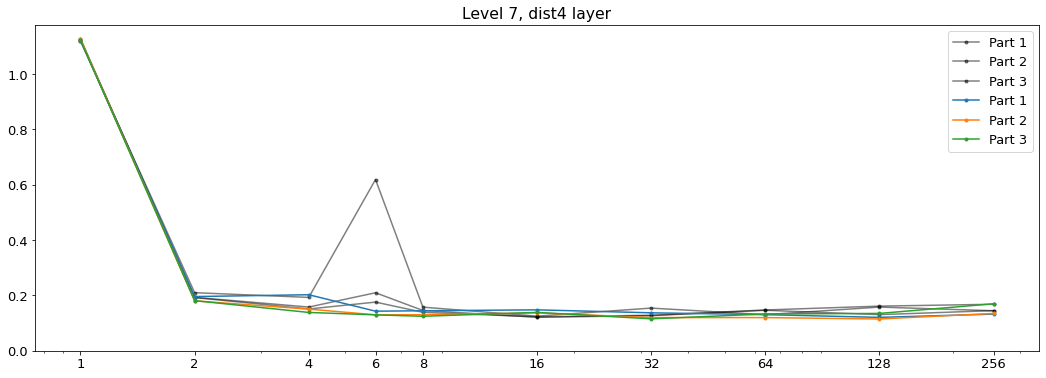

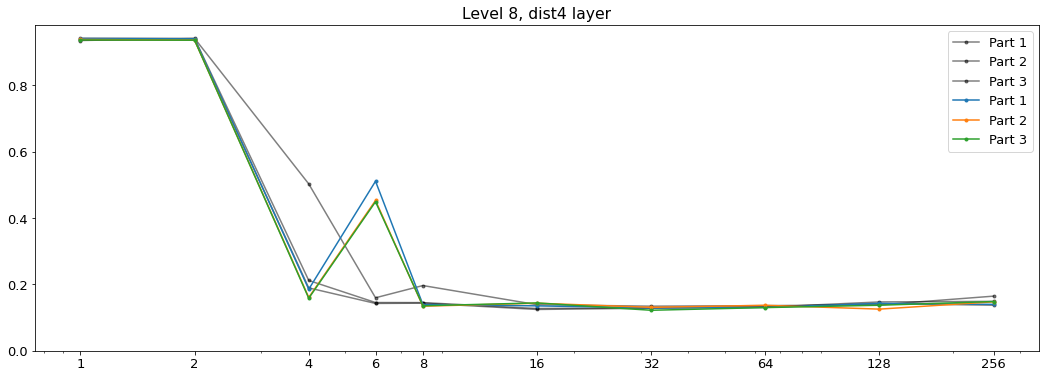

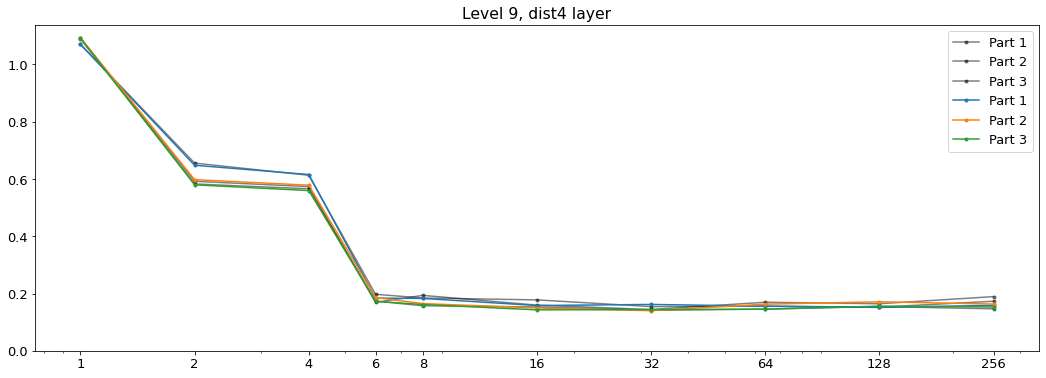

direct


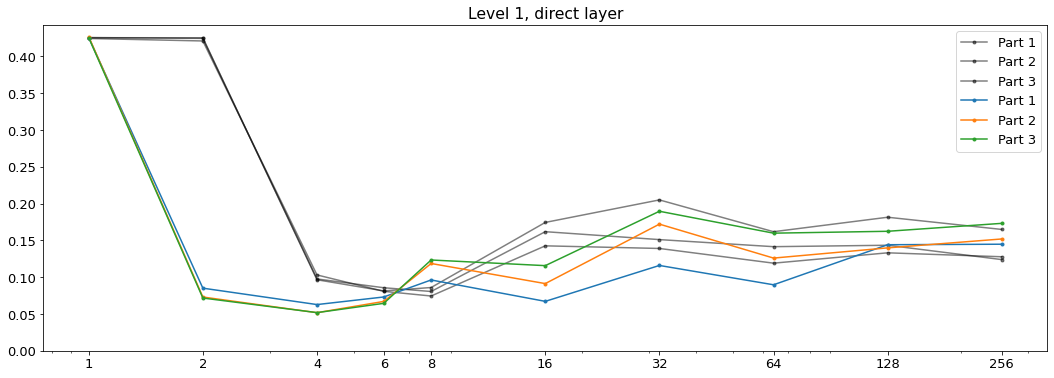

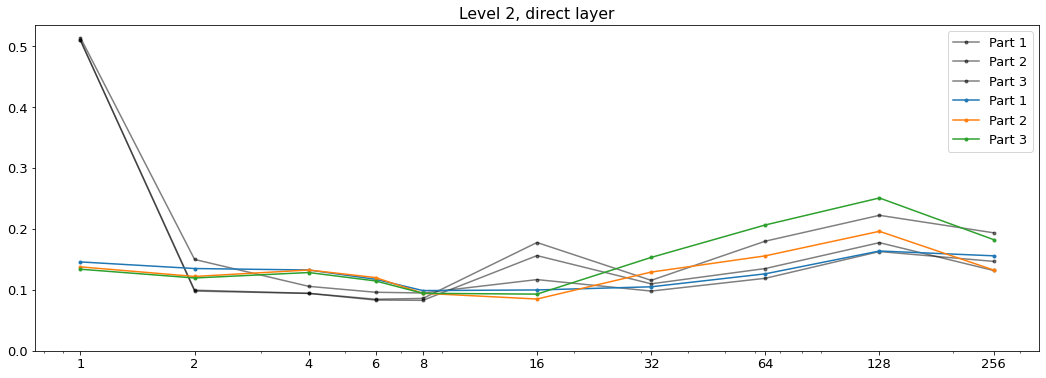

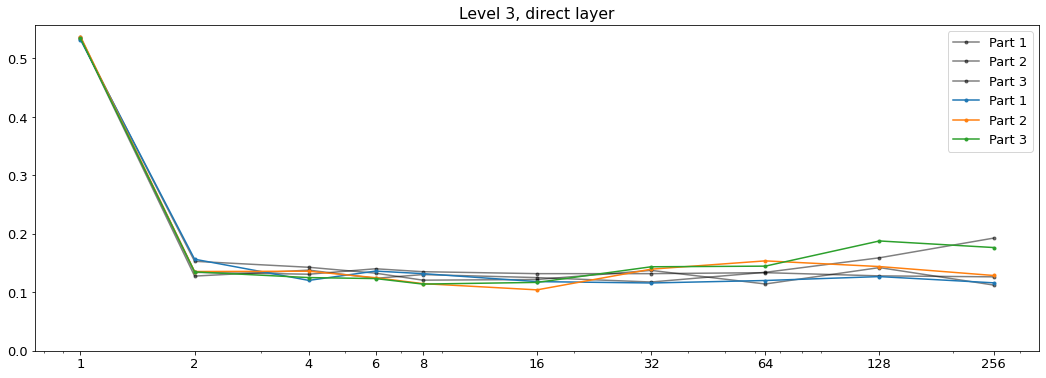

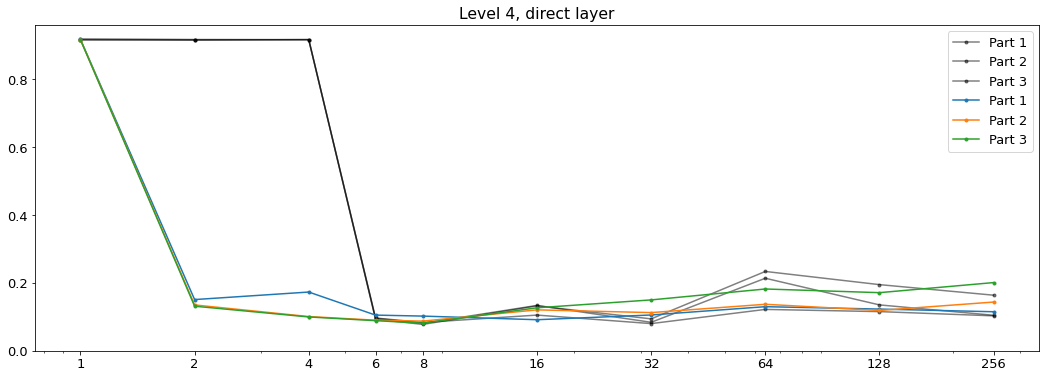

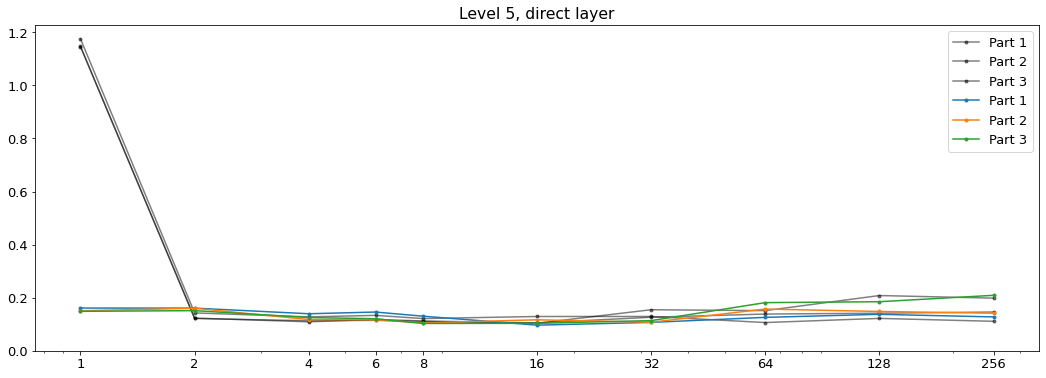

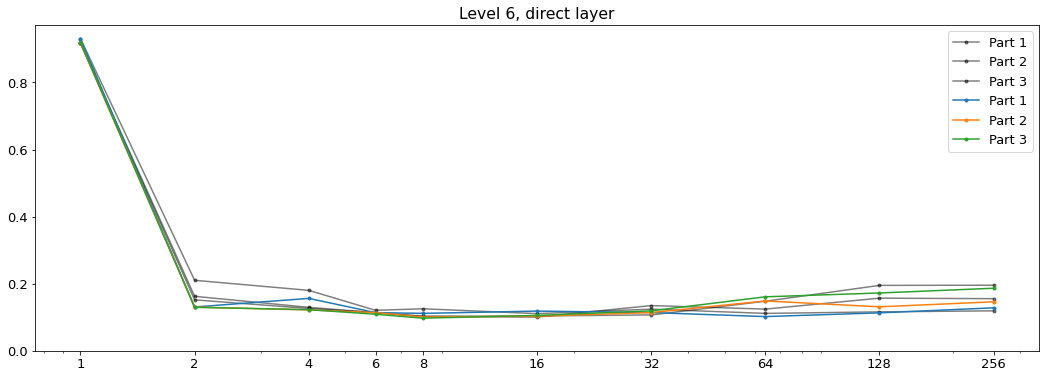

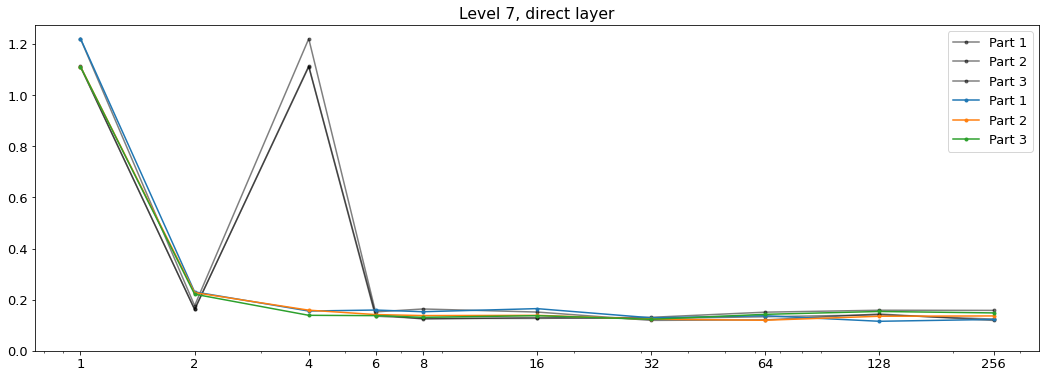

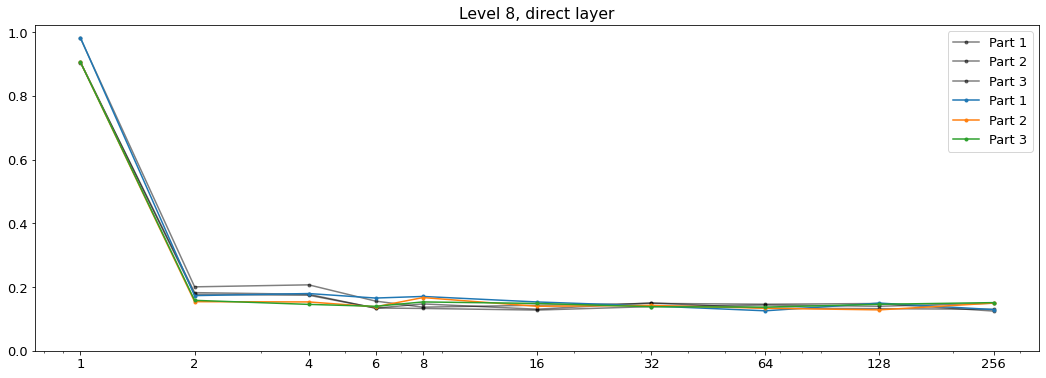

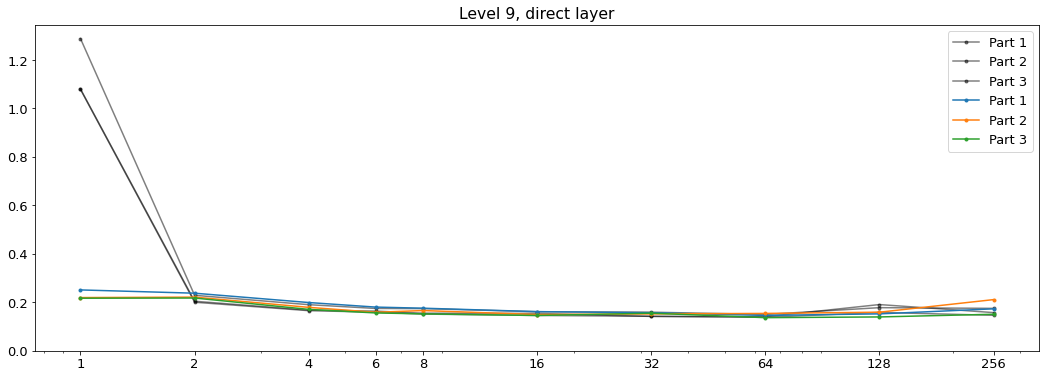

In [7]:
def plot_experiment_level_layer(results, layer, level, alpha=1, colors=None, parts=[1, 2, 3], ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(18, 6))
    if colors is None:
        colors = [None for i in range(3)]
    if not isinstance(colors, list):
        colors = [colors for i in range(3)]
    
    # select layer and level
    df = results[(results.layer == layer) & (results.level == level)]

    for i, j in enumerate(parts):
        df_part = df[df.part == f'part{j}']
        ax.plot(df_part['nodes'], df_part['WSPL'], '.-', alpha=alpha, color=colors[i], label=f'Part {j}')
    
    ax.set_ylim(0)
    ax.set_xscale('log')
    ax.set_xticks(df_part['nodes'].values)
    ax.set_xticklabels(df_part['nodes'].values)
    ax.set_title("Level {}, {} layer".format(level, layer))
    ax.legend()
    
    return ax

# plot performance for each layer, at each level
for layer in results.layer.unique():
    print(layer)

    for level in results.level.unique():
        f, ax = plt.subplots(1, 1, figsize=(18, 6))
        
        plot_experiment_level_layer(results_prev, layer, level, alpha=0.5, colors='k', ax=ax)
        plot_experiment_level_layer(results, layer, level, alpha=1, ax=ax)

        plt.show()

## Create table of best run, per level, per layer
For each level and each layer, select best WSPL

In [44]:
df_a = results_prev.groupby(['level', 'layer'])['WSPL'].min()
df_b = results.groupby(['level', 'layer'])['WSPL'].min()
df = pd.concat((df_a, df_b), axis=1)
df.columns = ["Baseline", "With LightGBM"]
df

Baseline  With LightGBM
level layer                          
1     dense   0.088031       0.066428
      direct  0.074454       0.051810
      dist2   0.055126       0.054951
      dist4   0.062630       0.053817
2     dense   0.088350       0.081509
      direct  0.082794       0.084955
      dist2   0.083923       0.093347
      dist4   0.092523       0.085004
3     dense   0.106994       0.108954
      direct  0.112470       0.104240
      dist2   0.105965       0.108524
      dist4   0.109114       0.107482
4     dense   0.079545       0.069243
      direct  0.077743       0.081421
      dist2   0.078448       0.076612
      dist4   0.071642       0.075360
5     dense   0.093289       0.088701
      direct  0.103808       0.096613
      dist2   0.110131       0.101506
      dist4   0.099504       0.095313
6     dense   0.098190       0.099843
      direct  0.100415       0.097264
      dist2   0.095824       0.097009
      dist4   0.096236       0.096614
7     dense   0.117629       0.115962
      direct  0.118617       0.115426
      dist2   0.120707       0.112705
      dist4   0.121149       0.115031
8     dense   0.125954       0.123932
      direct  0.124689       0.125539
      dist2   0.119655       0.126673
      dist4   0.124606       0.122211
9     dense   0.141018       0.140903
      direct  0.138119       0.136782
      dist2   0.140975       0.148593
      dist4   0.141423       0.140220
12    dense   0.266642            NaN
      direct  0.266018            NaN
      dist2   0.295591            NaN
      dist4   0.279758            NaN

1


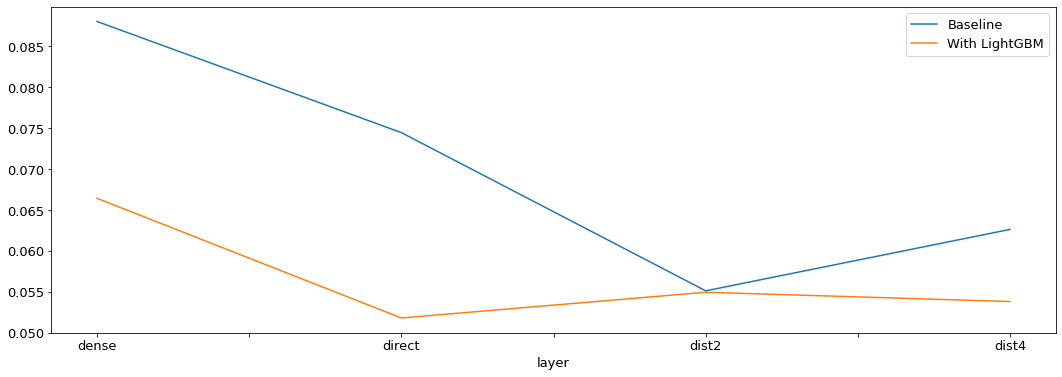

2


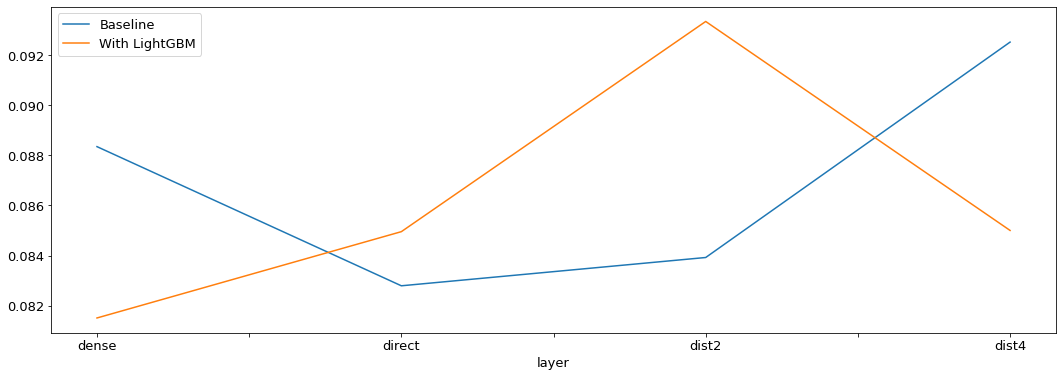

3


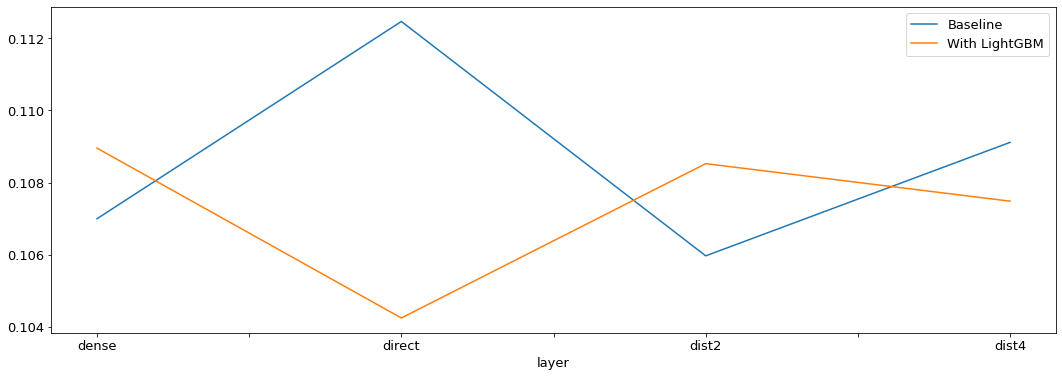

4


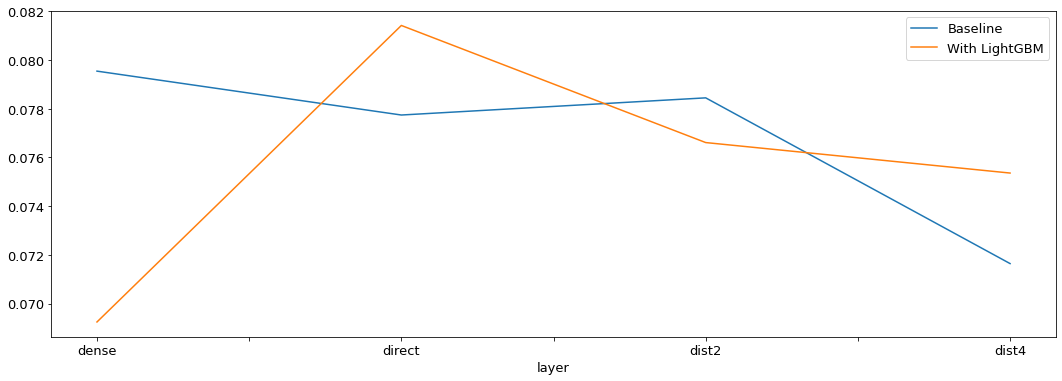

5


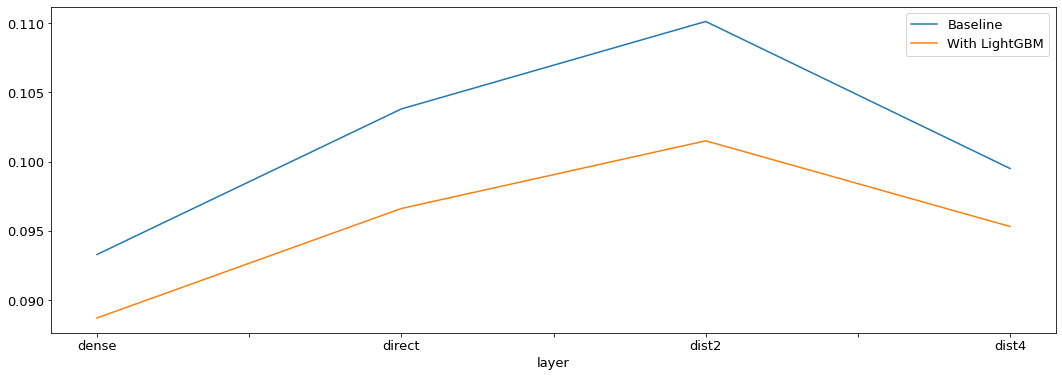

6


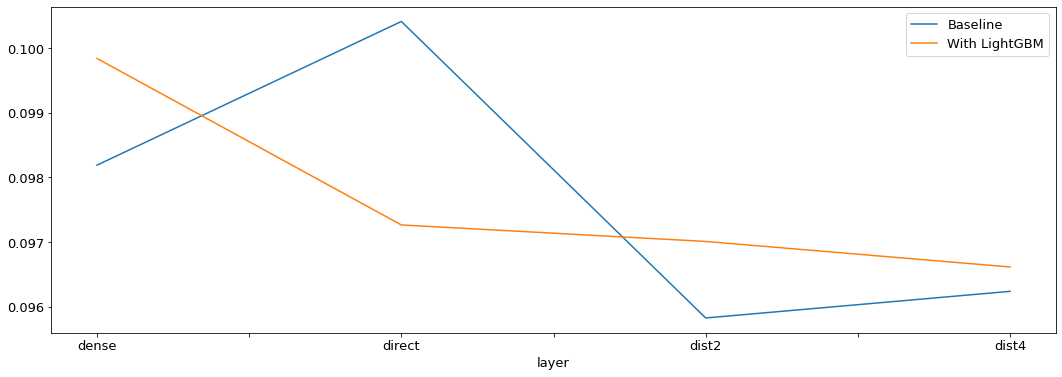

7


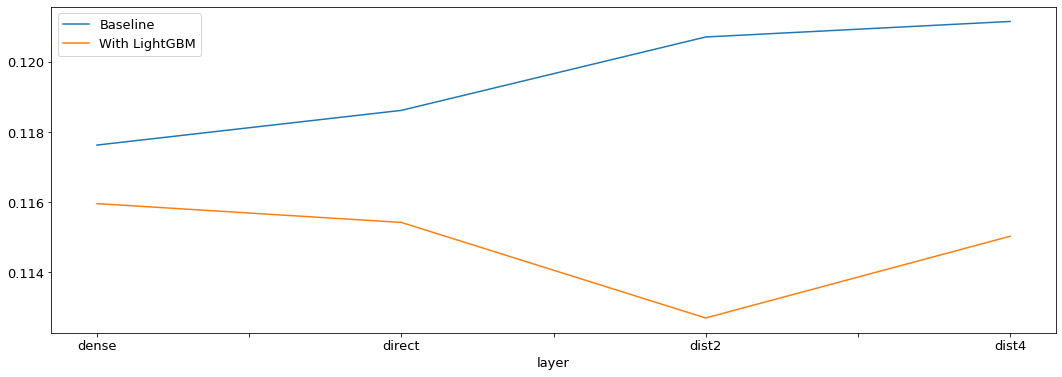

8


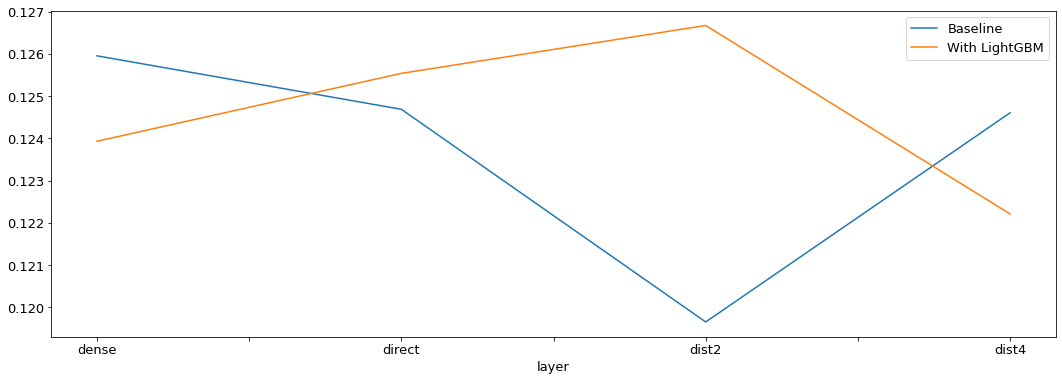

9


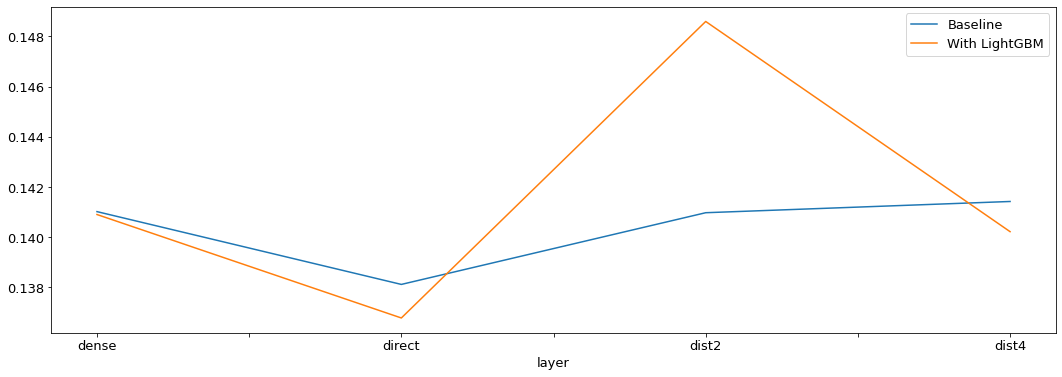

In [9]:
for level in range(1, 9+1):
    print(level)
    f, ax = plt.subplots(figsize=(18, 6))
    df.loc[level].plot(ax=ax)
    plt.show()

In [45]:
df_table = df.unstack().T
df_table

level                       1         2         3         4         5   \
              layer                                                      
Baseline      dense   0.088031  0.088350  0.106994  0.079545  0.093289   
              direct  0.074454  0.082794  0.112470  0.077743  0.103808   
              dist2   0.055126  0.083923  0.105965  0.078448  0.110131   
              dist4   0.062630  0.092523  0.109114  0.071642  0.099504   
With LightGBM dense   0.066428  0.081509  0.108954  0.069243  0.088701   
              direct  0.051810  0.084955  0.104240  0.081421  0.096613   
              dist2   0.054951  0.093347  0.108524  0.076612  0.101506   
              dist4   0.053817  0.085004  0.107482  0.075360  0.095313   

level                       6         7         8         9         12  
              layer                                                     
Baseline      dense   0.098190  0.117629  0.125954  0.141018  0.266642  
              direct  0.100415  0.118617  0.124689  0.138119  0.266018  
              dist2   0.095824  0.120707  0.119655  0.140975  0.295591  
              dist4   0.096236  0.121149  0.124606  0.141423  0.279758  
With LightGBM dense   0.099843  0.115962  0.123932  0.140903       NaN  
              direct  0.097264  0.115426  0.125539  0.136782       NaN  
              dist2   0.097009  0.112705  0.126673  0.148593       NaN  
              dist4   0.096614  0.115031  0.122211  0.140220       NaN

In [46]:
print(df_table.to_latex())

\begin{tabular}{llrrrrrrrrrr}
\toprule
              & level &        1  &        2  &        3  &        4  &        5  &        6  &        7  &        8  &        9  &        12 \\
{} & layer &           &           &           &           &           &           &           &           &           &           \\
\midrule
Baseline & dense &  0.088031 &  0.088350 &  0.106994 &  0.079545 &  0.093289 &  0.098190 &  0.117629 &  0.125954 &  0.141018 &  0.266642 \\
              & direct &  0.074454 &  0.082794 &  0.112470 &  0.077743 &  0.103808 &  0.100415 &  0.118617 &  0.124689 &  0.138119 &  0.266018 \\
              & dist2 &  0.055126 &  0.083923 &  0.105965 &  0.078448 &  0.110131 &  0.095824 &  0.120707 &  0.119655 &  0.140975 &  0.295591 \\
              & dist4 &  0.062630 &  0.092523 &  0.109114 &  0.071642 &  0.099504 &  0.096236 &  0.121149 &  0.124606 &  0.141423 &  0.279758 \\
With LightGBM & dense &  0.066428 &  0.081509 &  0.108954 &  0.069243 &  0.088701 &  0.099843 &  

## Plot per level, part 3

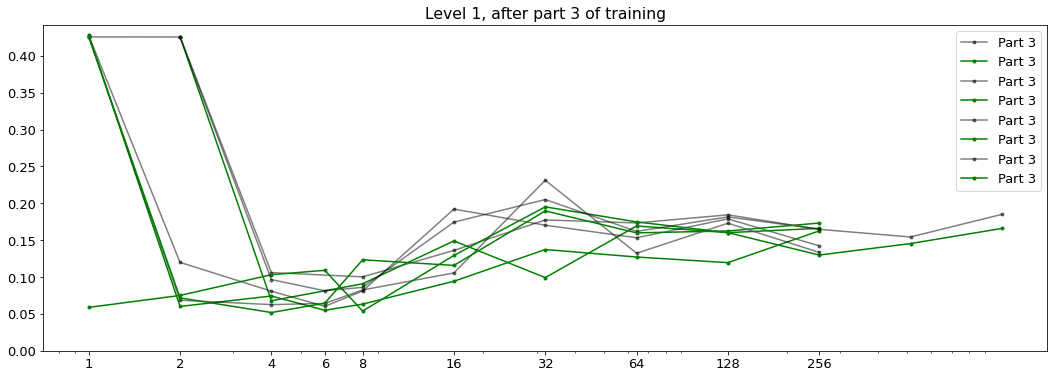

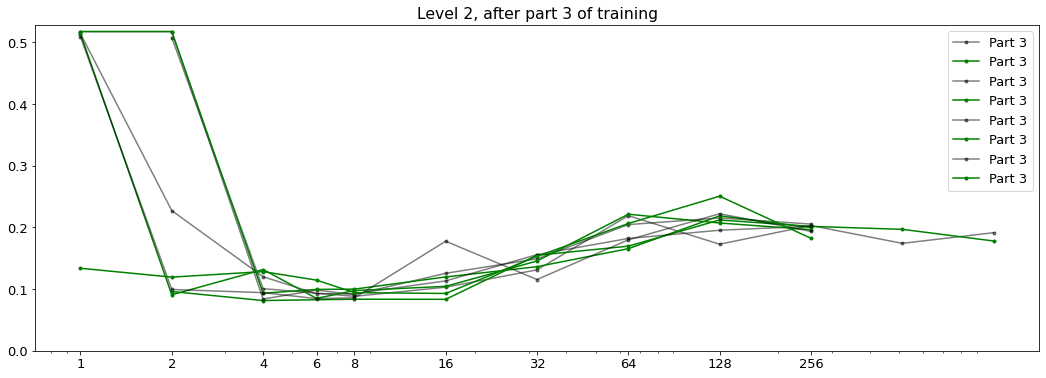

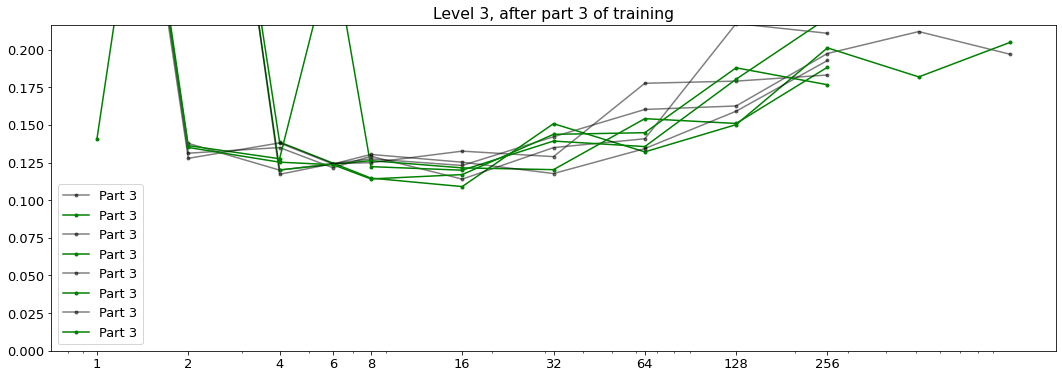

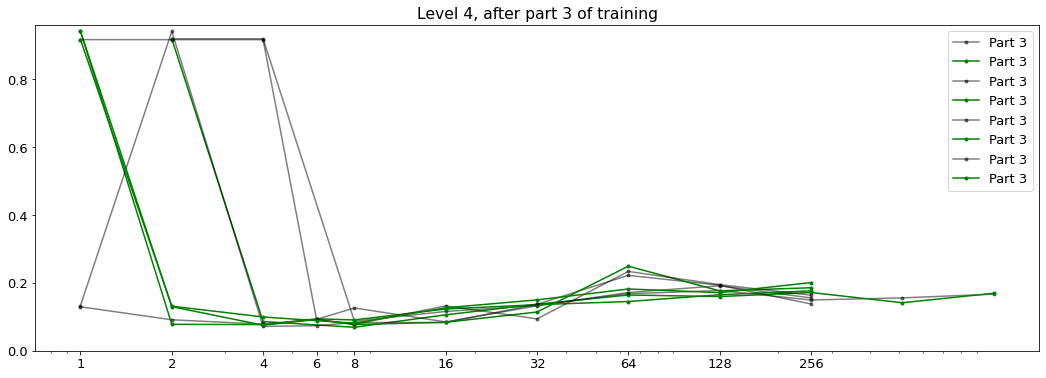

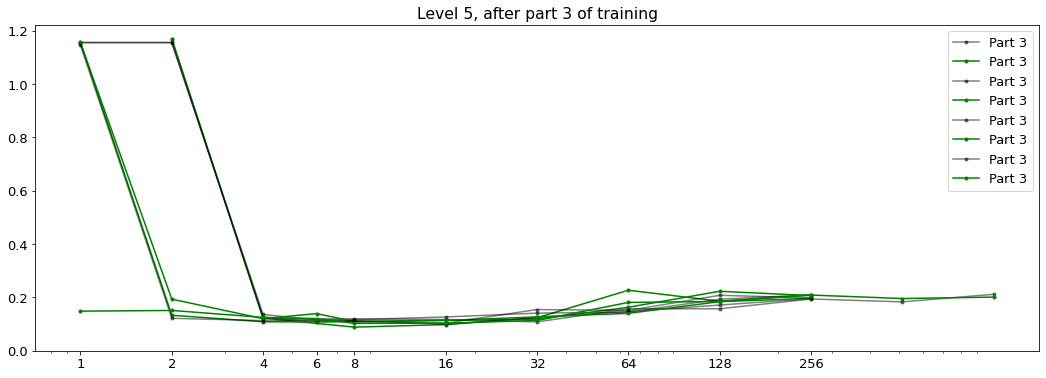

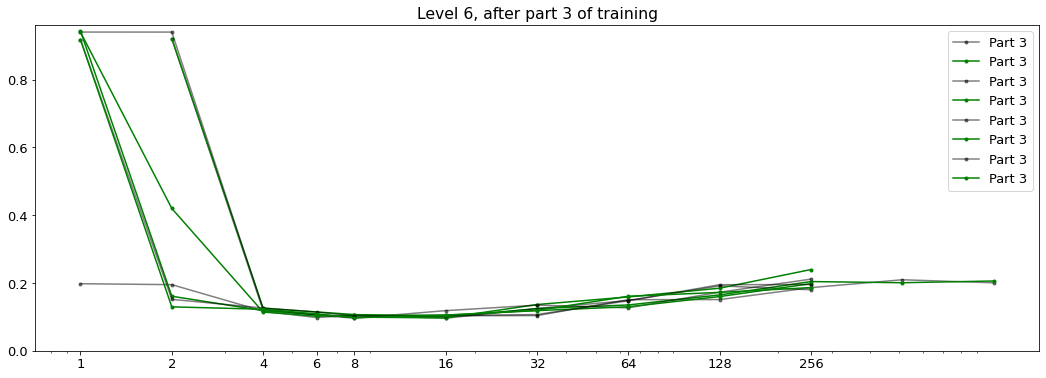

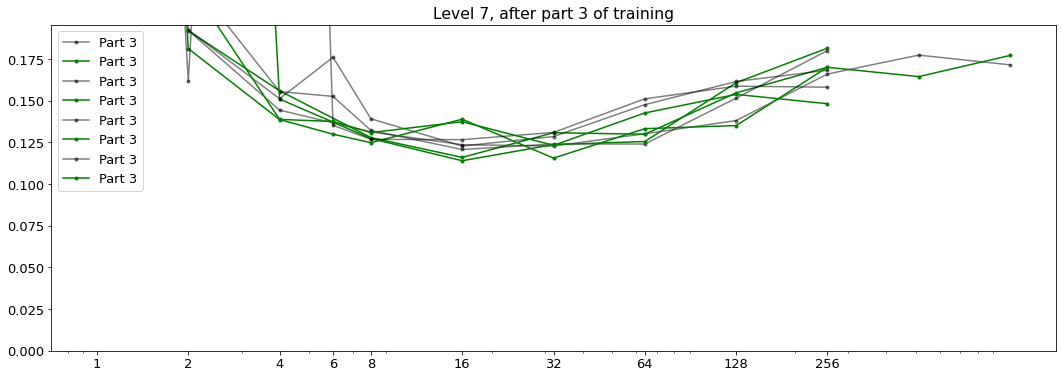

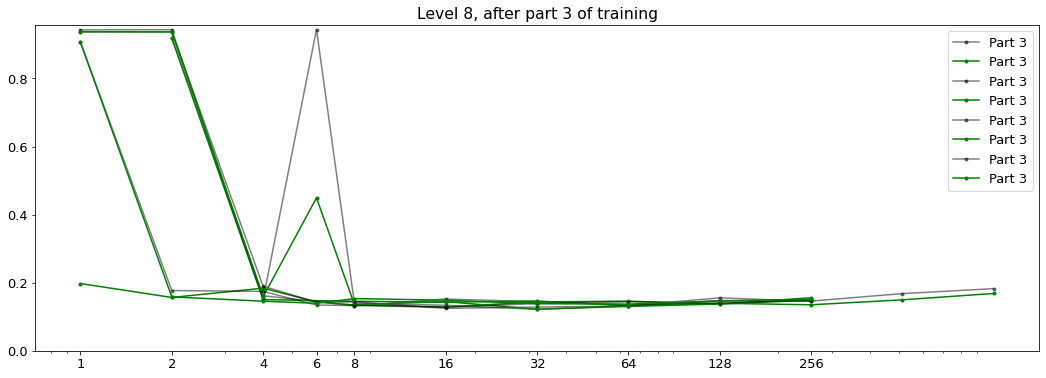

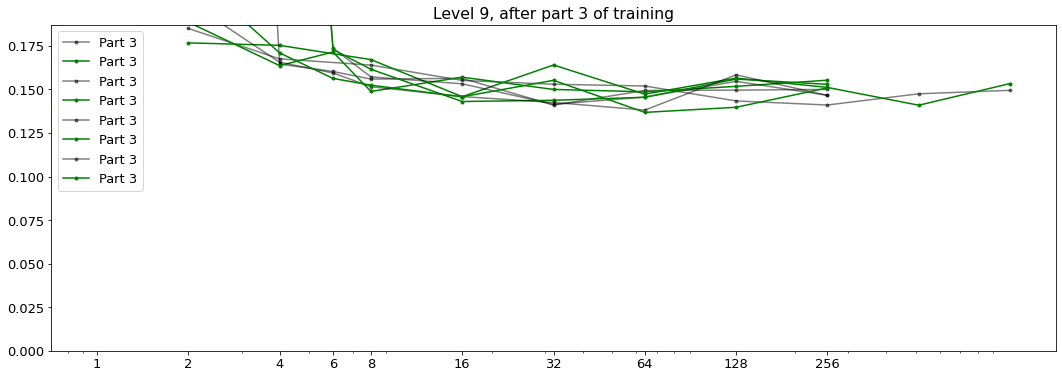

In [12]:
# plot performance for each level, after part 3
for level in results.level.unique():
    
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    for layer in results.layer.unique():
        plot_experiment_level_layer(results_prev, layer, level, parts=[3], colors='k', alpha=0.5, ax=ax)
        plot_experiment_level_layer(results, layer, level, parts=[3], colors='g', alpha=1, ax=ax)

    ax.set_title("Level {}, after part 3 of training".format(level))
    plt.show()

### Zoom-in

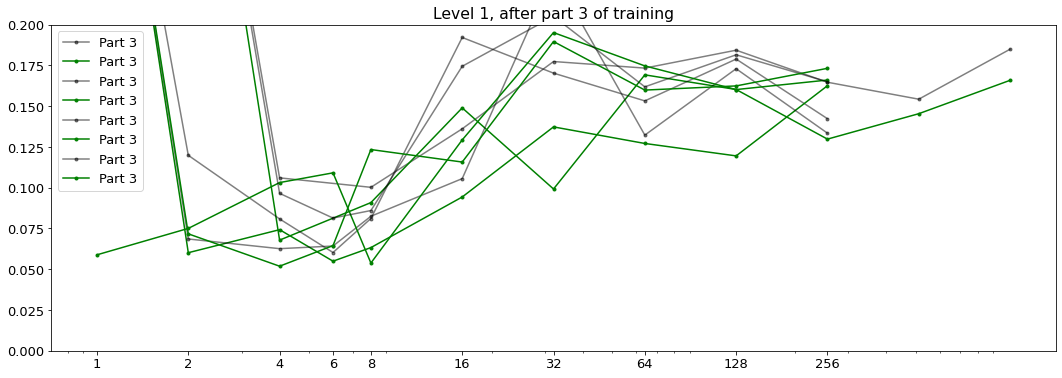

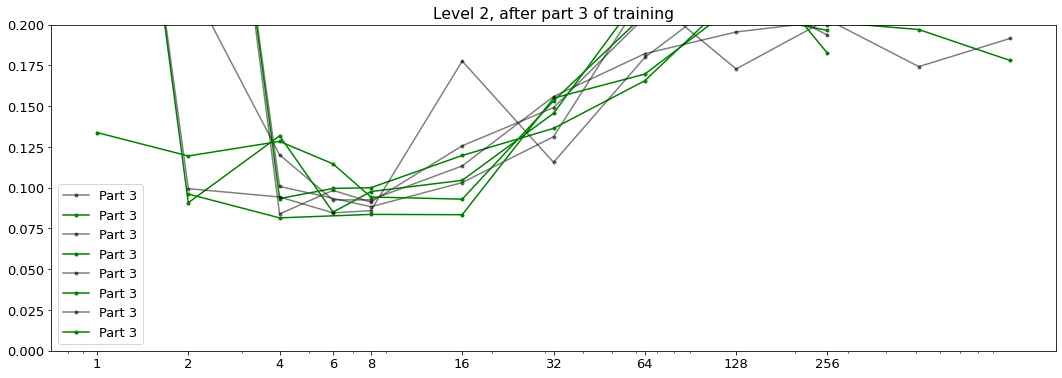

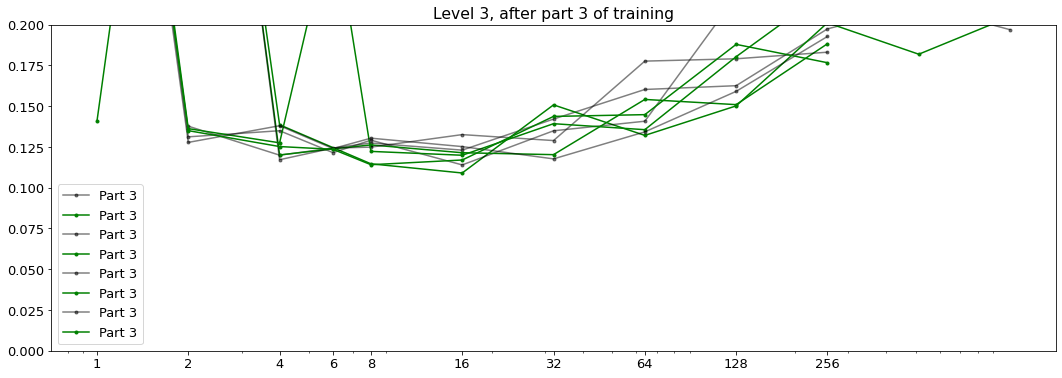

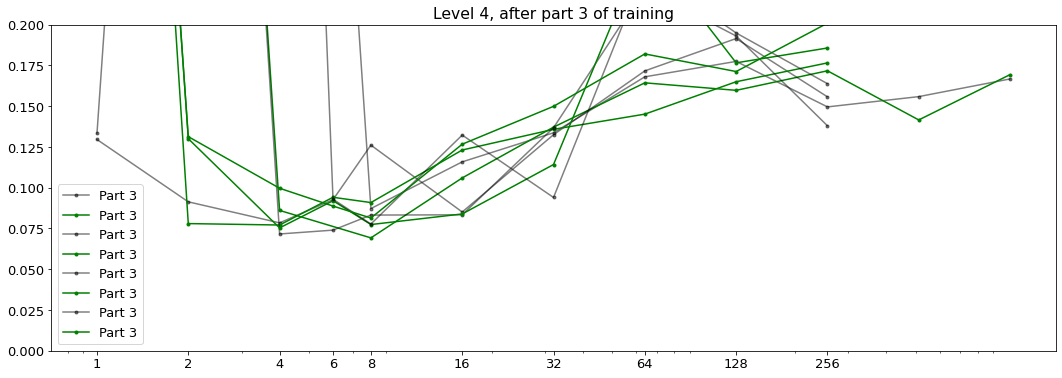

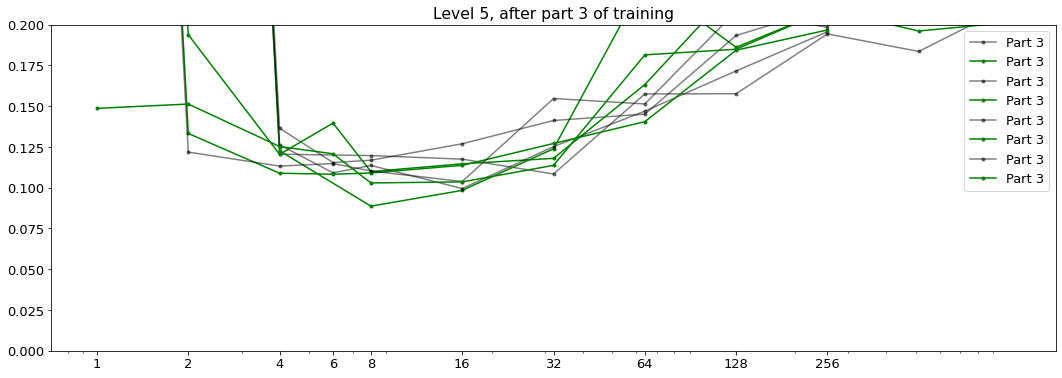

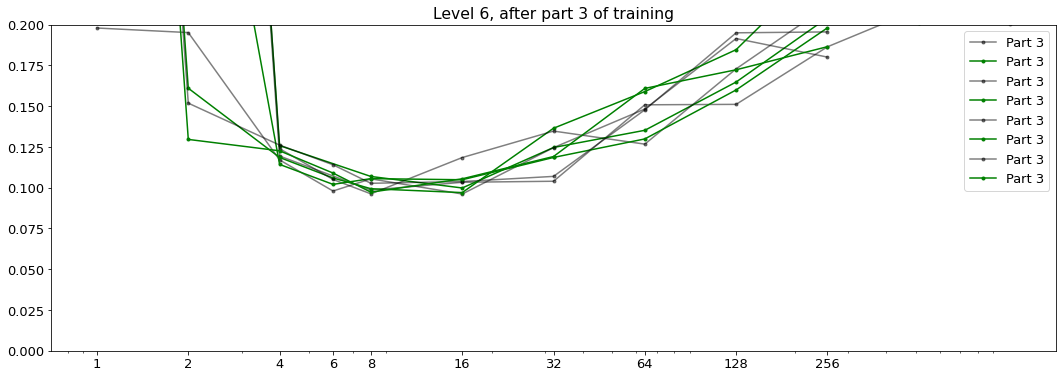

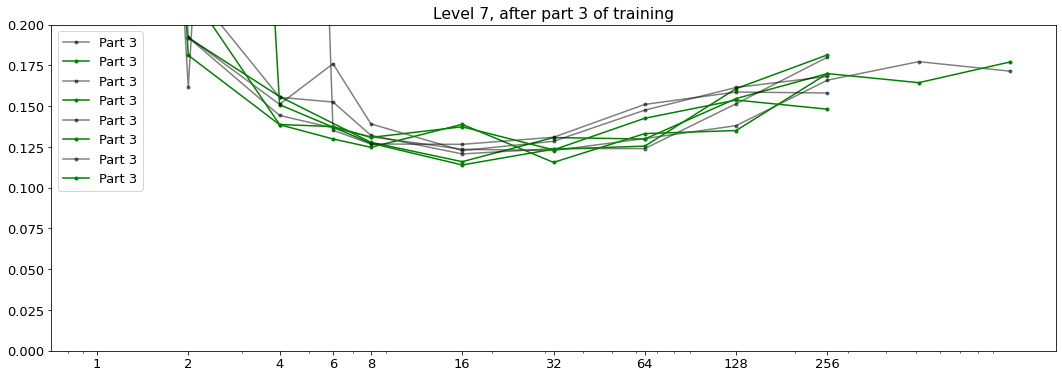

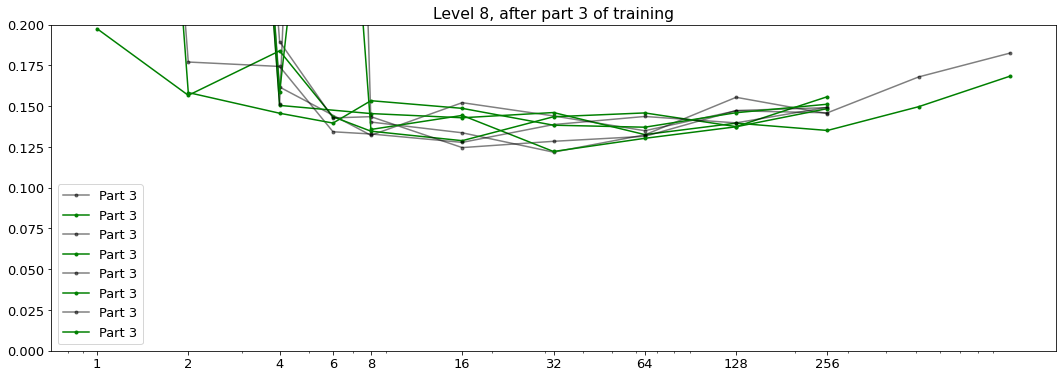

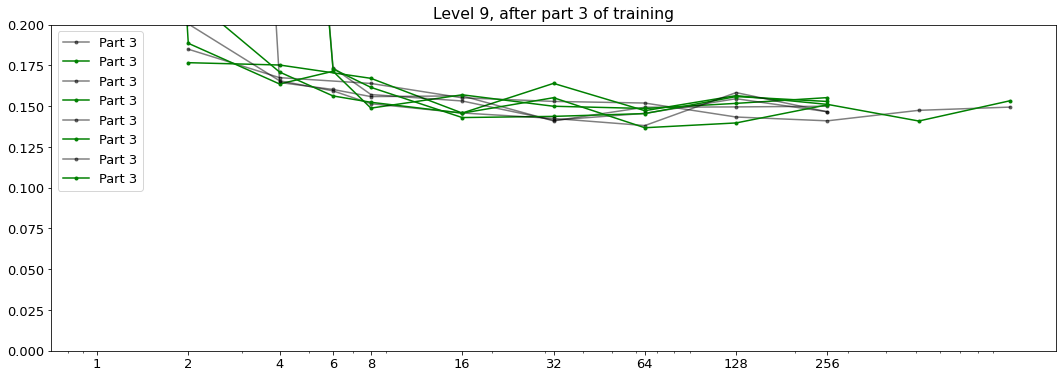

In [13]:
# plot performance for each level, after part 3
for level in results.level.unique():
    
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    for layer in results.layer.unique():
        plot_experiment_level_layer(results_prev, layer, level, parts=[3], colors='k', alpha=0.5, ax=ax)
        plot_experiment_level_layer(results, layer, level, parts=[3], colors='g', alpha=1, ax=ax)
    
    ax.set_ylim(0, 0.2)
    ax.set_title("Level {}, after part 3 of training".format(level))
    plt.show()

## Best for each level

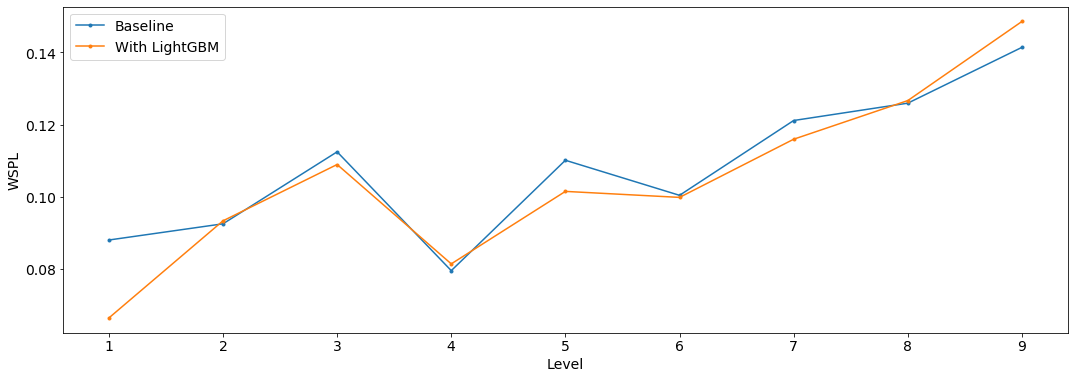

In [53]:
best_a = df_table.loc["Baseline"].max()
best_b = df_table.loc["With LightGBM"].max()

f, ax = plt.subplots(1, 1, figsize=(18, 6))
ax.plot(best_a.iloc[0:9], '.-', label="Baseline")
ax.plot(best_b, '.-', label="With LightGBM")
ax.legend()
ax.set_xlabel("Level")
ax.set_ylabel("WSPL")
f.savefig("lgb.pdf")
plt.show()

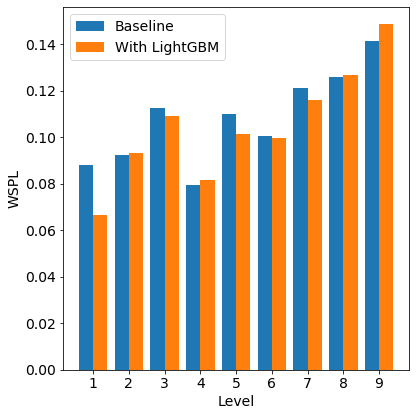

In [103]:
best_a = df_table.loc["Baseline"].max()
best_b = df_table.loc["With LightGBM"].max()

f, ax = plt.subplots(1, 1, figsize=(6, 6))

x = np.arange(1, 1+9)
ax.bar(x-0.2, height=best_a.iloc[0:9], width=0.4, label="Baseline")
ax.bar(x+0.2, height=best_b.iloc[0:9], width=0.4, label="With LightGBM")
ax.legend()
ax.set_xlabel("Level")
ax.set_ylabel("WSPL")
ax.set_xticks(x)
f.tight_layout()
f.savefig("lgb_bar.pdf")
plt.show()

In [27]:
print("Mean WSPL baseline: {:.5f}".format(best_a.mean()))
print("Mean WSPL with LightGBM: {:.5f}".format(best_b.mean()))
print("Improvement: {:.2%}".format((best_a.mean() - best_b.mean())/best_a.mean()))

Mean WSPL baseline: 0.10796
Mean WSPL with LightGBM: 0.10475
Improvement: 2.98%


## Report: custom layer

In [62]:
df = results_prev
df = df[df.part == 'part3']
df

,layer,level,nodes,part,WSPL
126,direct,1,1,part3,0.425534
127,direct,1,2,part3,0.425403
128,direct,1,4,part3,0.096548
129,direct,1,6,part3,0.081396
130,direct,1,8,part3,0.086005
...,...,...,...,...,...
7,dist4,12,128,part3,0.279758
8,dist4,12,256,part3,0.287956
15,dense,12,256,part3,0.266642
16,dense,12,512,part3,0.594725


1
Empty DataFrame
Columns: [layer, level, nodes, part, WSPL]
Index: []
2
Empty DataFrame
Columns: [layer, level, nodes, part, WSPL]
Index: []
3
Empty DataFrame
Columns: [layer, level, nodes, part, WSPL]
Index: []
4
Empty DataFrame
Columns: [layer, level, nodes, part, WSPL]
Index: []
5
Empty DataFrame
Columns: [layer, level, nodes, part, WSPL]
Index: []
6
Empty DataFrame
Columns: [layer, level, nodes, part, WSPL]
Index: []
7
Empty DataFrame
Columns: [layer, level, nodes, part, WSPL]
Index: []
8
Empty DataFrame
Columns: [layer, level, nodes, part, WSPL]
Index: []
9
Empty DataFrame
Columns: [layer, level, nodes, part, WSPL]
Index: []
12


ValueError: Lengths must match to compare

In [80]:
y = []
labels = []
no_nodes = []

for layer in ['dense', 'dist2', 'dist4', 'direct']:
    labels.append(layer)
    
    score = df[df.layer == layer].groupby('level').WSPL.min()

    for level in score.index:
        step2 = df[(df.layer == layer) & (df.level == level)]
        step3 = step2[step2.WSPL == score.loc[level]]
        no_nodes.append(step3.nodes.values[0])
    
    y.append(score.values)
labels

['dense', 'dist2', 'dist4', 'direct']

In [82]:
no_nodes = [no_nodes[0:10], no_nodes[10:20], no_nodes[20:30], no_nodes[30:40]]
no_nodes

[[8, 8, 4, 8, 32, 8, 32, 8, 256, 256],
 [6, 4, 16, 4, 6, 16, 16, 32, 32, 128],
 [4, 6, 4, 4, 16, 8, 16, 16, 32, 128],
 [6, 6, 32, 8, 16, 8, 16, 16, 64, 64]]

In [88]:
nodes_table = df_table.copy().loc['Baseline']
nodes_table = pd.DataFrame(data=no_nodes, index=labels, columns=nodes_table.columns)
nodes_table

level,1,2,3,4,5,6,7,8,9,12
dense,8,8,4,8,32,8,32,8,256,256
dist2,6,4,16,4,6,16,16,32,32,128
dist4,4,6,4,4,16,8,16,16,32,128
direct,6,6,32,8,16,8,16,16,64,64


In [90]:
print(nodes_table.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
level &  1  &  2  &  3  &  4  &  5  &  6  &  7  &  8  &   9  &   12 \\
\midrule
dense  &   8 &   8 &   4 &   8 &  32 &   8 &  32 &   8 &  256 &  256 \\
dist2  &   6 &   4 &  16 &   4 &   6 &  16 &  16 &  32 &   32 &  128 \\
dist4  &   4 &   6 &   4 &   4 &  16 &   8 &  16 &  16 &   32 &  128 \\
direct &   6 &   6 &  32 &   8 &  16 &   8 &  16 &  16 &   64 &   64 \\
\bottomrule
\end{tabular}



In [26]:
y

[array([0.10025084, 0.0883495 , 0.11996646, 0.08721191, 0.10841531,
        0.09854283, 0.12281962, 0.13214613, 0.14101847, 0.2666419 ]),
 array([0.06027054, 0.08392327, 0.11398365, 0.07844784, 0.11543562,
        0.09613953, 0.12070696, 0.12180513, 0.14097495, 0.29559148]),
 array([0.06263034, 0.09252304, 0.11717322, 0.07164163, 0.09950393,
        0.09623601, 0.12279401, 0.12460597, 0.14142253, 0.27975759]),
 array([0.08139562, 0.0845892 , 0.11768269, 0.07774303, 0.10380844,
        0.10270904, 0.12660455, 0.12780235, 0.13811878, 0.27266041])]

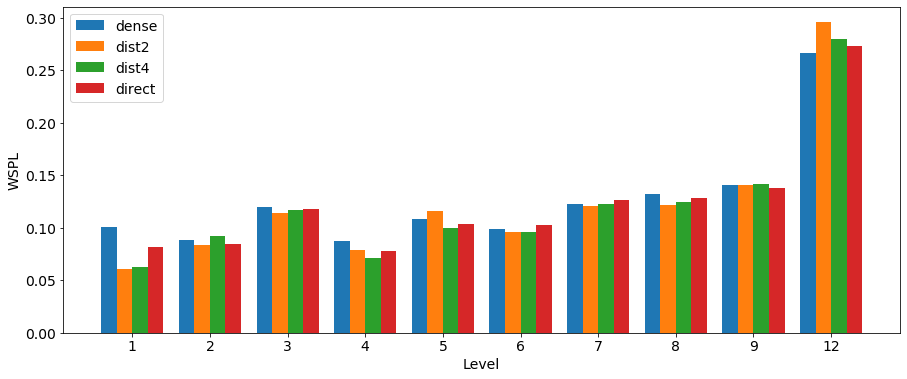

In [54]:
f, ax = plt.subplots(1, 1, figsize=(15, 6))

x = np.arange(len(y[0]))

for i, label in enumerate(labels):
    ax.bar(x+0.2*i, height=y[i], width=0.2, label=label)

ax.legend()
ax.set_xticks(x+0.3)
ax.set_xticklabels(list(range(1, 1+9)) + [12])
ax.set_xlabel("Level")
ax.set_ylabel("WSPL")

f.savefig("custom_layers.pdf")
plt.show()